# Tutorial 1 - Intro to neural ODE based Neural Networks
The goal of this tutorial is to get familiar with the fundamentals of the code basis and ensure it is running  
The notebook utilizes code from the package torchdiffeq and code from https://github.com/borjanG/2021-dynamical-systems

In [22]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt



# Juptyer magic: For export. Makes the plots size right for the screen
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Data preparation

Data point of X: [ 0.64012617 -0.51424613] 
Data type X: float64

Data point of y: 1 
Data type y: float64


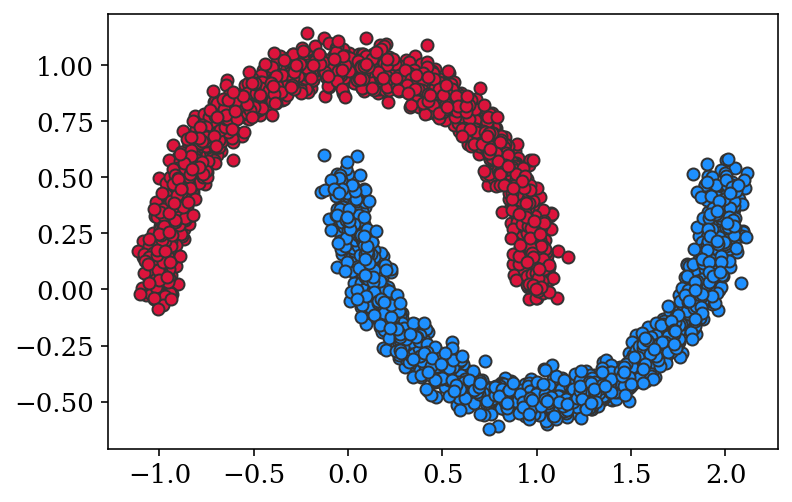

In [38]:
#We load a typical toy dataset that requires a nonlinear classification model to achieve high accuracy
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

#the noise describes how large the standard deviation of the data distribution is
noise = 0.05

#Load 3000 instances of data points

X, y = make_moons(n_samples = 3000, noise = noise)

#alternative toy data set
# X, y = make_circles(3000, noise=noise, factor=0.15)


print('Data point of X:', X[0], '\nData type X:', X.dtype)
print('\nData point of y:', y[0], '\nData type y:', X.dtype)

#Visualizing the data
data_0 = X[y == 0]
data_1 = X[y == 1]
fig = plt.figure()
plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", color = 'crimson')
plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", color = 'dodgerblue')
plt.show()

As typical for machine learning algorithms, we split the data into a training set and test set.  
To use the pytorch frameset, we recast the data as tensors and create Dataloaders used to conveniently load the training and test data during training and validation.

In [33]:
from torch.utils.data import DataLoader,TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2 )

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)

dataloader = DataLoader(data_line, batch_size=64)
dataloader_viz = DataLoader(test, batch_size=128)

In [34]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[ 0.4098,  0.8706],
        [ 0.2735, -0.2069],
        [ 1.8899,  0.3889],
        [-0.1791,  0.9801],
        [-0.5451,  0.7685],
        [ 0.3279, -0.2139],
        [ 0.5273, -0.3501],
        [ 0.9301,  0.3564],
        [-0.6244,  0.7156],
        [-0.9310,  0.2262]]) tensor([0, 1, 1, 0, 0, 1, 1, 0, 0, 0])


# Model dynamics

In [35]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 5.0, 10  
dt = T/num_steps
bound = 0.
fp = False
cross_entropy = True


non_linearity = 'relu' #'tanh'
architecture = 'bottleneck' #outside

v_steps = 5
training = True #train new network or load saved one

anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 
print(anode)


NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): ReLU()
      (fc1_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
        (6): Linear(in_features=2, out_features=2, bias=True)
        (7): Linear(in_features=2, out_features=2, bias=True)
        (8): Linear(in_features=2, out_features=2, bias=True)
        (9): Linear(in_features=2, out_features=2, bias=True)
      )
      (fc3_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_

In [36]:
from models.training import Trainer

trainer_anode = Trainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, 
                         bound=bound, fixed_projector=fp, verbose = True) 

print("Model's state_dict:")
for param_tensor in anode.state_dict():
    print(param_tensor, "\t", anode.state_dict()[param_tensor].size())

Model's state_dict:
flow.dynamics.fc1_time.0.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.0.bias 	 torch.Size([2])
flow.dynamics.fc1_time.1.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.1.bias 	 torch.Size([2])
flow.dynamics.fc1_time.2.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.2.bias 	 torch.Size([2])
flow.dynamics.fc1_time.3.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.3.bias 	 torch.Size([2])
flow.dynamics.fc1_time.4.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.4.bias 	 torch.Size([2])
flow.dynamics.fc1_time.5.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.5.bias 	 torch.Size([2])
flow.dynamics.fc1_time.6.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.6.bias 	 torch.Size([2])
flow.dynamics.fc1_time.7.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.7.bias 	 torch.Size([2])
flow.dynamics.fc1_time.8.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_time.8.bias 	 torch.Size([2])
flow.dynamics.fc1_time.9.weight 	 torch.Size([2, 2])
flow.dynamics.fc1_

In [28]:
num_epochs = 100 #number of optimization runs in which the dataset is used for gradient decent
trainer_anode.train(dataloader, num_epochs)


Epoch 0/38
Loss: 0.854
Accuracy: 0.438

Epoch 10/38
Loss: 0.848
Accuracy: 0.359

Epoch 20/38
Loss: 0.827
Accuracy: 0.375

Epoch 30/38
Loss: 0.727
Accuracy: 0.406
Epoch 1: 0.776

Epoch 0/38
Loss: 0.702
Accuracy: 0.484

Epoch 10/38
Loss: 0.679
Accuracy: 0.484

Epoch 20/38
Loss: 0.672
Accuracy: 0.562

Epoch 30/38
Loss: 0.602
Accuracy: 0.641
Epoch 2: 0.638

Epoch 0/38
Loss: 0.596
Accuracy: 0.719

Epoch 10/38
Loss: 0.578
Accuracy: 0.672

Epoch 20/38
Loss: 0.573
Accuracy: 0.750

Epoch 30/38
Loss: 0.527
Accuracy: 0.766
Epoch 3: 0.552

Epoch 0/38
Loss: 0.534
Accuracy: 0.766

Epoch 10/38
Loss: 0.516
Accuracy: 0.844

Epoch 20/38
Loss: 0.503
Accuracy: 0.797

Epoch 30/38
Loss: 0.469
Accuracy: 0.859
Epoch 4: 0.490

Epoch 0/38
Loss: 0.482
Accuracy: 0.781

Epoch 10/38
Loss: 0.462
Accuracy: 0.891

Epoch 20/38
Loss: 0.436
Accuracy: 0.891

Epoch 30/38
Loss: 0.412
Accuracy: 0.922
Epoch 5: 0.433

Epoch 0/38
Loss: 0.430
Accuracy: 0.859

Epoch 10/38
Loss: 0.411
Accuracy: 0.906

Epoch 20/38
Loss: 0.372
Accu

## Generate a gif of the evolution of the input points through the neural network

In [29]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif')
    break

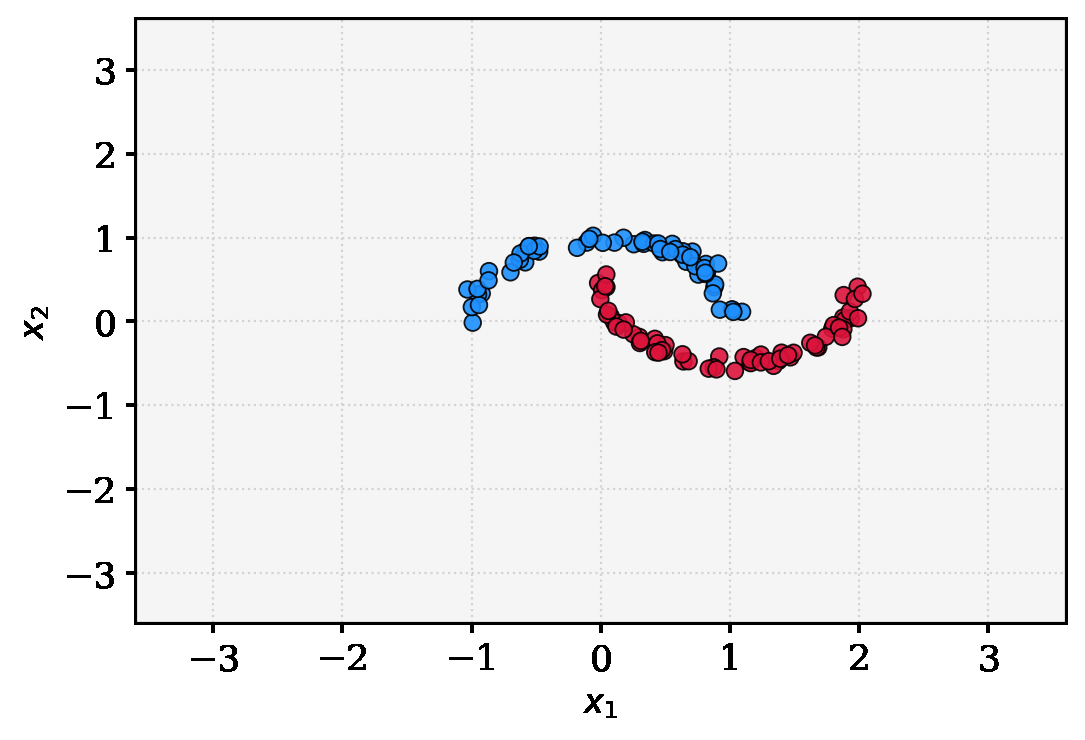

In [30]:
#Display of the generated gif

from IPython.display import Image
Image(filename="trajectory.gif", retina = True)

Observe that the blue and red data points are getting seperated further as time passes.

In [43]:
from plots.plots import plt_classifier

for X_viz, y_viz in dataloader_viz:
    plt_classifier(anode, X_test, y_test, num_steps=10, save_fig = '1generalization.pdf') 
    break


ValueError: too many values to unpack (expected 2)